In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from adapt.feature_based import FA

from skopt import BayesSearchCV
from skopt.space import Categorical, Integer
from sklearn.metrics import classification_report

from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix
from matplotlib import pyplot as plt
import seaborn as sns


np.int = int


In [2]:
Xs_train    = pd.read_pickle('X_s_train.pkl')
Xs_test     = pd.read_pickle('X_s_test.pkl')[Xs_train.columns]
Xt_train    = pd.read_pickle('X_t_train.pkl')[Xs_train.columns]
Xt_test     = pd.read_pickle('X_t_test.pkl')[Xs_train.columns]
ys_train    = pd.read_pickle('y_s_train.pkl')
ys_test     = pd.read_pickle('y_s_test.pkl')
yt_train    = pd.read_pickle('y_t_train.pkl')
yt_test     = pd.read_pickle('y_t_test.pkl')

In [3]:
def conf_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true=y_true, y_pred=y_pred)
    # Define class labels (change to your own class labels)
    class_labels = ["Class 1", "Class 2", "Class 3"]
    
    # Create a heatmap of the confusion matrix
    plt.figure(figsize=(8, 6))
    sns.set(font_scale=1.2)  # Adjust the font scale for better readability
    sns.heatmap(cm, annot=True, cmap="Blues", fmt="d", cbar=False, square=True,
                xticklabels=class_labels, yticklabels=class_labels)
    
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

In [4]:
class_weights = compute_class_weight('balanced', classes=np.unique(ys_train), y=ys_train)

In [32]:
from sklearn.model_selection import GridSearchCV

forest_clf = RandomForestClassifier(class_weight={idx + 1: weight for idx, weight in enumerate(class_weights)})

search_space = {
        "bootstrap": Categorical([True, False]), # values for boostrap can be either True or False
        "max_depth": Integer(1, 10), 
        "max_features": Categorical(['sqrt','log2']), 
        "min_samples_leaf": Integer(5, 15),
        "min_samples_split": Integer(7, 10),
        "n_estimators": Integer(50, 1000)
    }

search_space = {
        "bootstrap": [False], 
        "max_depth": list(range(1, 11)), 
        "max_features": ['sqrt','log2'], 
        "min_samples_leaf": list(range(8, 13)),
        "min_samples_split": list(range(7, 11)),
        "n_estimators": list(range(120, 801))
    }

forest_bayes_search = BayesSearchCV(forest_clf, search_space, n_iter=150,
                                    scoring="f1_weighted", n_jobs=-1, cv=5
                                    )
#grid_search = GridSearchCV(estimator=forest_clf, param_grid=search_space, cv=5, #scoring='f1_weighted', n_jobs=-1)
#grid_search.fit(Xs_train, ys_train)
forest_bayes_search.fit(Xs_train, ys_train)

best_params = forest_bayes_search.best_params_
best_model = forest_bayes_search.best_estimator_
#best_params = grid_search.best_params_
#best_model = grid_search.best_estimator_

KeyboardInterrupt: 

In [ ]:
best_params

--------------- TRAIN -----------------------


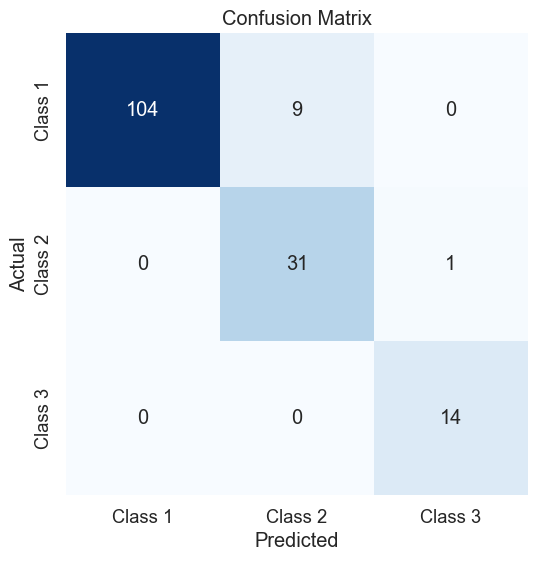

              precision    recall  f1-score   support

           1       1.00      0.92      0.96       113
           2       0.78      0.97      0.86        32
           3       0.93      1.00      0.97        14

    accuracy                           0.94       159
   macro avg       0.90      0.96      0.93       159
weighted avg       0.95      0.94      0.94       159

--------------- TEST -----------------------


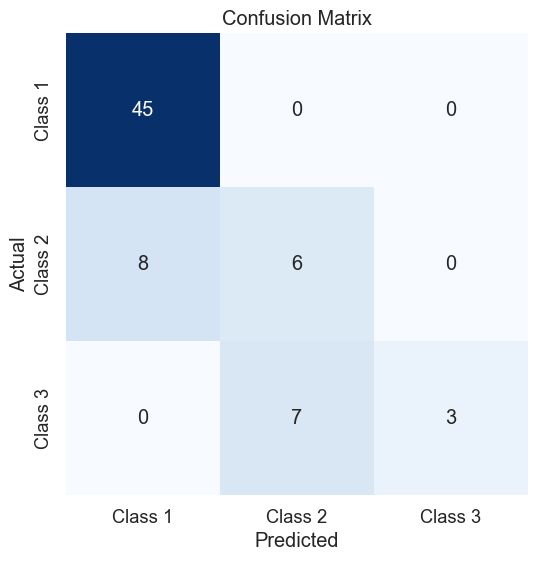

              precision    recall  f1-score   support

           1       0.85      1.00      0.92        45
           2       0.46      0.43      0.44        14
           3       1.00      0.30      0.46        10

    accuracy                           0.78        69
   macro avg       0.77      0.58      0.61        69
weighted avg       0.79      0.78      0.76        69


In [34]:
print('--------------- TRAIN -----------------------')
conf_matrix(ys_train, best_model.predict(Xs_train))
print(classification_report(ys_train, best_model.predict(Xs_train)))
print('--------------- TEST -----------------------')
conf_matrix(ys_test, best_model.predict(Xs_test))
print(classification_report(ys_test, best_model.predict(Xs_test)))

In [ ]:
def subsample_df(df, y, percentage):
    size_by_id = Xt_train.index.get_level_values(0).value_counts()
    number_rows_to_select = (size_by_id * percentage).astype(int)
    
    df_to_create = pd.DataFrame(columns=df.columns)
    selected_indices = []

    for id, id_group in df.groupby(level=0):
        selected_rows = id_group.sample(n=number_rows_to_select[id], random_state=42)
        df_to_create = pd.concat([df_to_create, selected_rows])
        selected_indices.extend(selected_rows.index)

    y_to_create = y.loc[selected_indices]
    
    return df_to_create, y_to_create


In [ ]:
#percent_to_select = 0.5  
#group_sizes = Xt_train.index.get_level_values(0)
#group_sizes = Xt_train.index.get_level_values(0).value_counts()
#rows_to_select = (group_sizes * percent_to_select).astype(int)
#selected_df = pd.DataFrame(columns=Xt_train.columns)
#selected_indices = []
# Randomly select rows for each ID
#for id_value, group in Xt_train.groupby(level=0):
#    selected_rows = group.sample(n=rows_to_select[id_value], random_state=42)
#    selected_df = pd.concat([selected_df, selected_rows])
#    selected_indices.extend(selected_rows.index)

# Reset the index of the selected DataFrame
#selected_df.reset_index(inplace=True)
#y_values = yt_train.loc[selected_indices]

selected_df, y_values = subsample_df(Xt_train, yt_train, 0.9)

model = FA(best_model, Xt=selected_df, yt=y_values, random_state=0)

model.fit(Xs_train, ys_train)


model.score(Xt_train, yt_train)

In [ ]:
print(classification_report(yt_train, model.predict(Xt_train)))

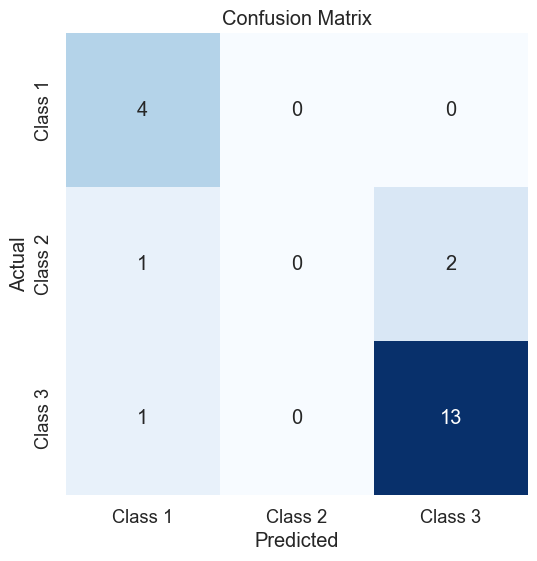

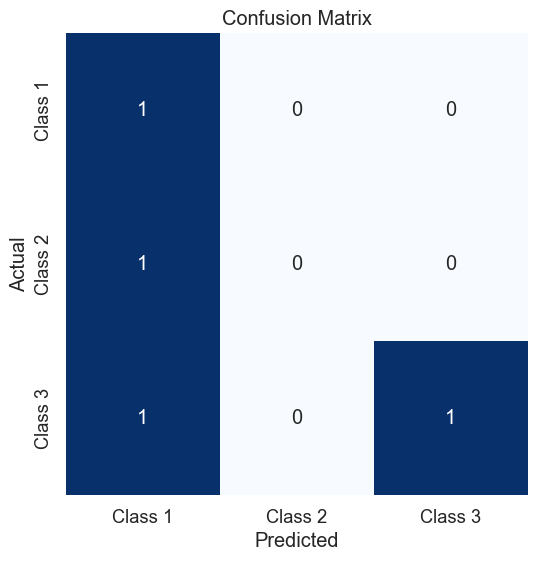

In [33]:
conf_matrix(yt_train, model.predict(Xt_train))
conf_matrix(yt_test, model.predict(Xt_test))


In [27]:
Xt_train

x__length  x__count_below_mean  \
1 2023-01-01 09:46:12.710   252160.0             127115.0   
  2023-01-01 10:01:12.710   367360.0             184931.0   
  2023-01-01 10:16:12.710   482560.0             242531.0   
  2023-01-01 10:31:12.710   597760.0             300496.0   
2 2023-01-01 09:11:33.679   252160.0             126212.0   
  2023-01-01 09:26:33.679   367360.0             183684.0   
  2023-01-01 09:41:33.679   482560.0             241575.0   
  2023-01-01 09:56:33.679   597760.0             298721.0   
  2023-01-01 10:11:33.679   712960.0             356823.0   
  2023-01-01 10:26:33.679   828160.0             414347.0   
  2023-01-01 10:41:33.679   943360.0             472220.0   
  2023-01-01 10:56:33.679  1058560.0             528497.0   
  2023-01-01 11:11:33.679  1173760.0             586803.0   
  2023-01-01 11:26:33.679  1288960.0             643844.0   
  2023-01-01 11:41:33.679  1404160.0             701482.0   
  2023-01-01 11:56:33.679  1519360.0             759258.0   
  2023-01-01 12:11:33.679  1634560.0             816533.0   
  2023-01-01 12:26:33.679  1749760.0             874132.0   
  2023-01-01 12:41:33.679  1864960.0             931076.0   
  2023-01-01 12:56:33.679  1980160.0             987850.0   
  2023-01-01 13:24:00.960  2095360.0            1045163.0   

                           x__ratio_value_number_to_time_series_length  \
1 2023-01-01 09:46:12.710                                     0.012940   
  2023-01-01 10:01:12.710                                     0.009168   
  2023-01-01 10:16:12.710                                     0.007191   
  2023-01-01 10:31:12.710                                     0.005857   
2 2023-01-01 09:11:33.679                                     0.011651   
  2023-01-01 09:26:33.679                                     0.008411   
  2023-01-01 09:41:33.679                                     0.006646   
  2023-01-01 09:56:33.679                                     0.005526   
  2023-01-01 10:11:33.679                                     0.004702   
  2023-01-01 10:26:33.679                                     0.004080   
  2023-01-01 10:41:33.679                                     0.003625   
  2023-01-01 10:56:33.679                                     0.003266   
  2023-01-01 11:11:33.679                                     0.002990   
  2023-01-01 11:26:33.679                                     0.002753   
  2023-01-01 11:41:33.679                                     0.002564   
  2023-01-01 11:56:33.679                                     0.002387   
  2023-01-01 12:11:33.679                                     0.002248   
  2023-01-01 12:26:33.679                                     0.002122   
  2023-01-01 12:41:33.679                                     0.002042   
  2023-01-01 12:56:33.679                                     0.001953   
  2023-01-01 13:24:00.960                                     0.003041   

                           x__cid_ce__normalize_True  \
1 2023-01-01 09:46:12.710                 710.984182   
  2023-01-01 10:01:12.710                 856.195599   
  2023-01-01 10:16:12.710                 981.220272   
  2023-01-01 10:31:12.710                1092.285741   
2 2023-01-01 09:11:33.679                 708.806122   
  2023-01-01 09:26:33.679                 855.594929   
  2023-01-01 09:41:33.679                 980.019645   
  2023-01-01 09:56:33.679                1091.611866   
  2023-01-01 10:11:33.679                1192.473056   
  2023-01-01 10:26:33.679                1284.791377   
  2023-01-01 10:41:33.679                1372.884875   
  2023-01-01 10:56:33.679                1453.368634   
  2023-01-01 11:11:33.679                1530.914476   
  2023-01-01 11:26:33.679                1603.839483   
  2023-01-01 11:41:33.679                1674.624878   
  2023-01-01 11:56:33.679                1741.614218   
  2023-01-01 12:11:33.679                1806.672336   
  2023-01-01 12:26:33.679                1869.8